# 4) Phrase Diversity (n-gram TTR)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Measure phrase diversity using Type-Token Ratio (TTR) for bigrams and trigrams.
- Compare lexical variety across two works by the same author.
- (Optional) Analyze diversity trends across sections/chapters within the texts.

Learning objectives:
- Understand and compute Type-Token Ratio (TTR) as a measure of lexical/phrasal diversity.
- Apply TTR to n-grams (bigrams, trigrams) to quantify phrase variety.
- Interpret TTR values: lower TTR suggests formulaic/repetitive phrasing, higher TTR indicates more varied expression.
- Produce reproducible diversity metrics and visualizations for literary analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to exclude common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. (Optional) Customize section-splitting regex to analyze diversity by chapter.

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- TTR formula: (unique n-grams) / (total n-grams). Values range from 0 to 1.
- Lower TTR: more repetition (e.g., epic poetry with formulaic epithets like "wine-dark sea").
- Higher TTR: more varied phrasing (e.g., experimental modernist prose).
- Section-wise analysis (optional cell) helps identify where diversity changes within a work.
- Compare TTR between your two books to see if the author's style evolved or differs by genre.
- Stopword removal may artificially inflate TTR by reducing common bigrams like "of the" or "in the".

**Goal:** Apply Type-Token Ratio (TTR) to bigrams and trigrams to measure phrase diversity in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [2]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
   "book1_path": "../data/Crime-punishment.txt",  # <-- change
    "book2_path": "../data/The-Brotherskaramazov.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [3]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [4]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2

len(tokens1), len(tokens2), len(tokens)

len(tokens), tokens[:12]


(568005,
 ['chapter',
  'i',
  'chapter',
  'ii',
  'chapter',
  'iii',
  'chapter',
  'iv',
  'chapter',
  'v',
  'chapter',
  'vi'])

## 2. Compute TTR for Bigrams & Trigrams

Type–Token Ratio for n-grams measures phrase variety.

$$\text{TTR}(S) = \frac{|\text{unique n-grams}|}{|\text{total n-grams}|}$$

In [5]:
def ttr(seq):
    return len(set(seq)) / max(1, len(seq))

# Combined corpus TTR
bigrams_list = list(zip(tokens, tokens[1:]))
trigrams_list = list(zip(tokens, tokens[1:], tokens[2:]))

ttr2_combined = ttr(bigrams_list)
ttr3_combined = ttr(trigrams_list)

# Book 1 TTR
bigrams_list_1 = list(zip(tokens1, tokens1[1:]))
trigrams_list_1 = list(zip(tokens1, tokens1[1:], tokens1[2:]))

ttr2_book1 = ttr(bigrams_list_1)
ttr3_book1 = ttr(trigrams_list_1)

# Book 2 TTR
bigrams_list_2 = list(zip(tokens2, tokens2[1:]))
trigrams_list_2 = list(zip(tokens2, tokens2[1:], tokens2[2:]))

ttr2_book2 = ttr(bigrams_list_2)
ttr3_book2 = ttr(trigrams_list_2)

# Create comparison DataFrame
summary_df = pd.DataFrame({
    "metric": ["bigram_TTR", "trigram_TTR"],
    "combined": [ttr2_combined, ttr3_combined],
    "book1": [ttr2_book1, ttr3_book1],
    "book2": [ttr2_book2, ttr3_book2]
})
summary_df

,metric,combined,book1,book2
0,bigram_TTR,0.316867,0.399889,0.353750
1,trigram_TTR,0.726595,0.794348,0.761856


## 2.1 Visualize TTR Comparison

Compare bigram and trigram diversity visually.

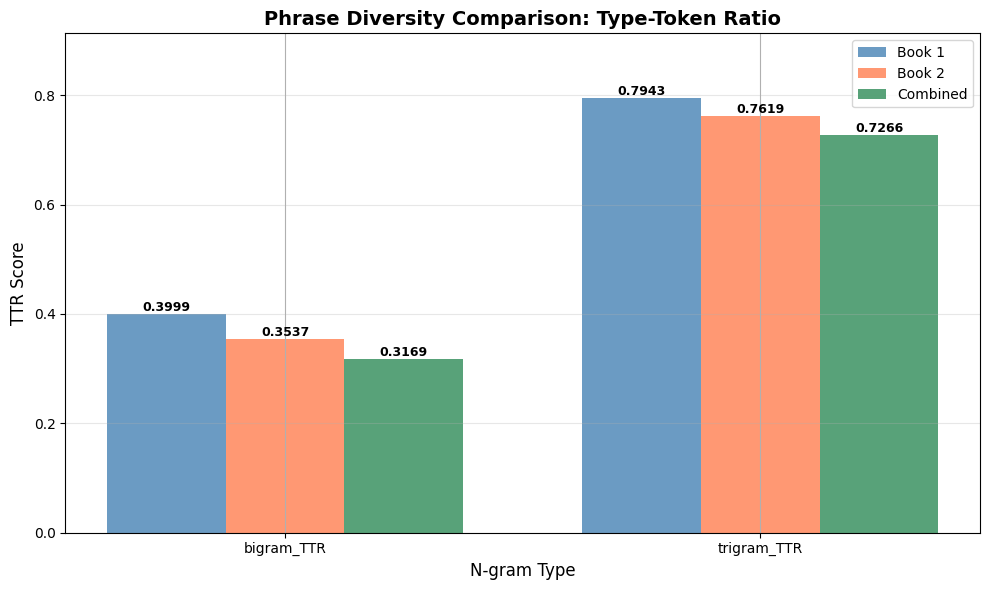

In [6]:
import numpy as np

fig_ttr, ax = plt.subplots(figsize=(10, 6))

# Set up grouped bar chart
x = np.arange(len(summary_df["metric"]))
width = 0.25

# Create bars for each book
bars1 = ax.bar(x - width, summary_df["book1"], width, label='Book 1', color='steelblue', alpha=0.8)
bars2 = ax.bar(x, summary_df["book2"], width, label='Book 2', color='coral', alpha=0.8)
bars3 = ax.bar(x + width, summary_df["combined"], width, label='Combined', color='seagreen', alpha=0.8)

# Customize plot
ax.set_ylabel("TTR Score", fontsize=12)
ax.set_xlabel("N-gram Type", fontsize=12)
ax.set_title("Phrase Diversity Comparison: Type-Token Ratio", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(summary_df["metric"])
ax.legend(fontsize=10)
ax.set_ylim(0, max(summary_df[["book1", "book2", "combined"]].max()) * 1.15)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. (Optional) Section-wise Diversity

If chapters/sections are detectable by regex, estimate diversity per section.



--- Section-wise TTR (The Brothers Karamazov) ---

|   section |   token_count |   bigram_TTR |   trigram_TTR |
|----------:|--------------:|-------------:|--------------:|
|         8 |          9766 |     0.716436 |      0.946129 |
|        11 |          2071 |     0.838164 |      0.977284 |
|        12 |          1702 |     0.87478  |      0.977059 |
|        13 |          1237 |     0.826861 |      0.957085 |
|        15 |          6387 |     0.742249 |      0.957087 |
|        21 |          5067 |     0.791749 |      0.965647 |
|        22 |          2645 |     0.830182 |      0.971245 |
|        23 |          2674 |     0.820426 |      0.967814 |
|        24 |          2300 |     0.828186 |      0.97302  |
|        28 |          1734 |     0.855741 |      0.979792 |
|        33 |          6510 |     0.771854 |      0.963122 |
|        36 |          6929 |     0.739463 |      0.954237 |
|        37 |          7057 |     0.715845 |      0.946279 |
|        38 |          5840 |    

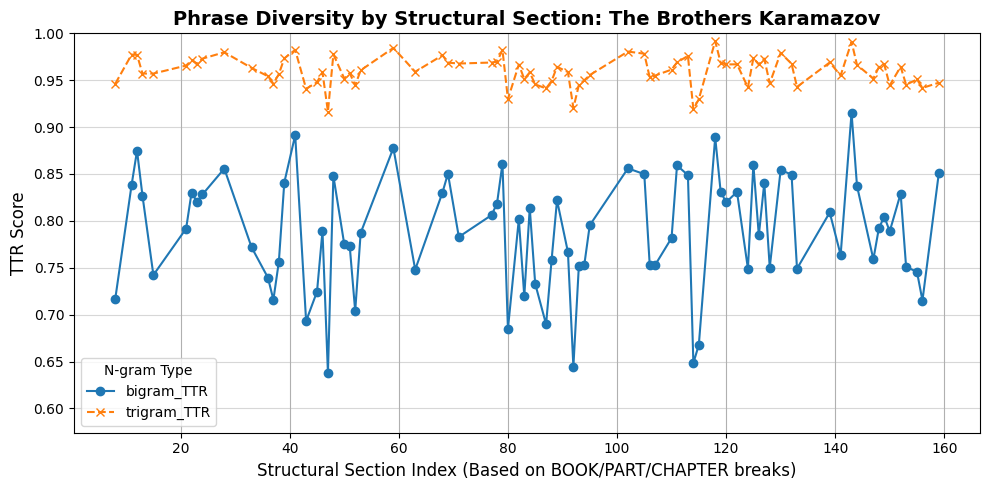

In [11]:
# -----------------------------------------------------------------------------------
# 3. (Optional) Section-wise Diversity
#
# This block performs TTR analysis on sequential structural sections of the text (Book 2).
# It uses a naive split by "book," "part," or "chapter" keywords.
# -----------------------------------------------------------------------------------

# NOTE: This code block assumes the following variables/functions from previous cells are defined:
# - CONFIG (with book paths set)
# - WORD_RE (word token regex)
# - ttr() (TTR calculation function)
# - load_text(), normalize_text(), strip_gutenberg() (text prep functions)
# - text2 (normalized text for The Brothers Karamazov)

import re
import pandas as pd
import matplotlib.pyplot as plt

# Load and process text2 (The Brothers Karamazov)
# If you run this file independently, you'll need the text2 variable defined.
# If running in your notebook after previous cells, 'text2' is already defined.
# Assuming 'text2' contains the normalized text of The Brothers Karamazov.

# --- IMPORTANT: Copy/Paste the logic to define text2 and tokens2 if running this block alone ---
# You need the load and normalize functions defined first!
# For a full notebook, these are already defined, so we use the result:
# full_text = text2

# --- Naive split by keywords: BOOK, PART, or CHAPTER ---
split_regex = r"\bbook\b|\bpart\b|\bchapter\b"
sections = re.split(split_regex, text2, flags=re.IGNORECASE)

# The first element is usually the front matter before the first marker, so we skip it.
sections_to_analyze = sections[1:]

rows = []
for i, sec in enumerate(sections_to_analyze, start=1):
    # Tokenize the current section
    toks = WORD_RE.findall(sec.lower())

    # Only analyze sections with a minimum of 1000 tokens for a meaningful TTR.
    if len(toks) > 1000:
        # Create n-grams
        b2 = list(zip(toks, toks[1:]))
        b3 = list(zip(toks, toks[1:], toks[2:]))

        # Calculate TTR and store results
        rows.append({
            "section": i,
            "token_count": len(toks),
            "bigram_TTR": ttr(b2),
            "trigram_TTR": ttr(b3)
        })

sec_df = pd.DataFrame(rows)

print("\n--- Section-wise TTR (The Brothers Karamazov) ---\n")
print(sec_df.to_markdown(index=False))

# --- Plotting the results ---
fig_sec, ax = plt.subplots(figsize=(10, 5))

# Use a line plot to show trends across the sequence of sections
sec_df.plot(x="section", y=["bigram_TTR","trigram_TTR"], kind='line', ax=ax, style=['-o', '--x'])

ax.set_title("Phrase Diversity by Structural Section: The Brothers Karamazov", fontsize=14, fontweight='bold')
ax.set_xlabel("Structural Section Index (Based on BOOK/PART/CHAPTER breaks)", fontsize=12)
ax.set_ylabel("TTR Score", fontsize=12)

# Set y-axis limits to clearly show fluctuations (starting slightly below the minimum TTR)
y_min = sec_df[['bigram_TTR', 'trigram_TTR']].min().min() * 0.9
ax.set_ylim(y_min, 1.0)

ax.legend(title='N-gram Type')
ax.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()


--- Analyzing Section-wise Diversity for Crime and Punishment (Book 1) ---

--- Section-wise TTR (Crime and Punishment) ---

|   section |   token_count |   bigram_TTR |   trigram_TTR |
|----------:|--------------:|-------------:|--------------:|
|        48 |          2765 |     0.804269 |      0.956931 |
|        50 |          2765 |     0.819826 |      0.964169 |
|        53 |          2744 |     0.795844 |      0.951495 |
|        54 |          1153 |     0.892361 |      0.976542 |
|        55 |          1571 |     0.882166 |      0.984704 |
|        56 |          3591 |     0.790251 |      0.969629 |
|        58 |          4794 |     0.764657 |      0.952838 |
|        60 |          4301 |     0.774884 |      0.955338 |
|        61 |          5125 |     0.766393 |      0.962132 |
|        62 |          4996 |     0.733534 |      0.947737 |
|        63 |          2425 |     0.77269  |      0.950475 |
|        64 |          4486 |     0.77369  |      0.951383 |
|        68 |       

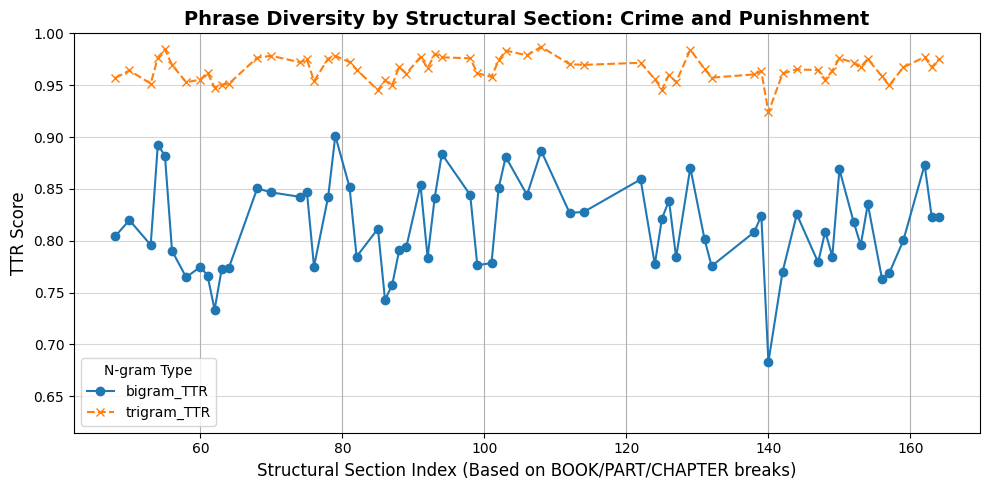

In [12]:
# -----------------------------------------------------------------------------------
# 3. (Optional) Section-wise Diversity for BOOK 1 (Crime and Punishment)
#
# This block performs TTR analysis on sequential structural sections of Book 1.
# -----------------------------------------------------------------------------------

import re
import pandas as pd
import matplotlib.pyplot as plt

print("\n--- Analyzing Section-wise Diversity for Crime and Punishment (Book 1) ---")

# --- Use text1 (Crime and Punishment) as the source text ---
full_text_book1 = text1

# --- Naive split by keywords: BOOK, PART, or CHAPTER ---
split_regex = r"\bbook\b|\bpart\b|\bchapter\b"
sections_book1 = re.split(split_regex, full_text_book1, flags=re.IGNORECASE)

# The first element is usually the front matter before the first marker, so we skip it.
sections_to_analyze_book1 = sections_book1[1:]

rows_book1 = []
for i, sec in enumerate(sections_to_analyze_book1, start=1):
    # Tokenize the current section
    toks = WORD_RE.findall(sec.lower())

    # Only analyze sections with a minimum of 1000 tokens for a meaningful TTR.
    if len(toks) > 1000:
        # Create n-grams
        b2 = list(zip(toks, toks[1:]))
        b3 = list(zip(toks, toks[1:], toks[2:]))

        # Calculate TTR and store results
        rows_book1.append({
            "section": i,
            "token_count": len(toks),
            "bigram_TTR": ttr(b2),
            "trigram_TTR": ttr(b3)
        })

sec_df_book1 = pd.DataFrame(rows_book1)

print("\n--- Section-wise TTR (Crime and Punishment) ---\n")
print(sec_df_book1.to_markdown(index=False))

# --- Plotting the results ---
fig_sec_book1, ax_book1 = plt.subplots(figsize=(10, 5))

# Use a line plot to show trends across the sequence of sections
sec_df_book1.plot(x="section", y=["bigram_TTR","trigram_TTR"], kind='line', ax=ax_book1, style=['-o', '--x'])

ax_book1.set_title("Phrase Diversity by Structural Section: Crime and Punishment", fontsize=14, fontweight='bold')
ax_book1.set_xlabel("Structural Section Index (Based on BOOK/PART/CHAPTER breaks)", fontsize=12)
ax_book1.set_ylabel("TTR Score", fontsize=12)

# Set y-axis limits to clearly show fluctuations
y_min_book1 = sec_df_book1[['bigram_TTR', 'trigram_TTR']].min().min() * 0.9
ax_book1.set_ylim(y_min_book1, 1.0)

ax_book1.legend(title='N-gram Type')
ax_book1.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

## 4. Notes

- Lower TTR suggests more formulaic phrasing (e.g., epic epithets).
- Compare the two works separately if you can split cleanly.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [16]:
# -----------------------------------------------------------------------------------
# 6. Export (tables/figures)
#
# This cell saves outputs into the local directory so you can add them to your report.
# -----------------------------------------------------------------------------------

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# Create a 'results' directory if it doesn't exist
# We'll use a local 'results' folder instead of '../results'
Path("results").mkdir(exist_ok=True)

# --- Save CSV table ---
# 'summary_df' should be the variable holding your TTR scores
try:
    summary_df.to_csv("results/TTR_table.csv", index=False)
    print("✓ Saved TTR_table.csv to results/")
except NameError:
    print("⚠ 'summary_df' not defined. Run the 'Compute TTR' cell first.")
except Exception as e:
    print(f"Error saving CSV: {e}")



# --- Save the main TTR comparison figure ---
# 'fig_ttr' should be the Figure object from your bar chart plot
try:
    fig_ttr.savefig("results/TTR_figure.png", dpi=200, bbox_inches="tight")
    print("✓ Saved TTR_figure.png to results/")
except NameError:
    print("⚠ 'fig_ttr' not defined. Run the 'Visualize TTR Comparison' cell first.")
except Exception as e:
    print(f"Error saving figure: {e}")

# --- (Optional) Save the Section Diversity figures ---
# If you also want to save the line plots from the optional section:

# Save 'The Brothers Karamazov' section plot
try:
    # 'fig_sec' was the name we used for the Book 2 plot
    fig_sec.savefig("results/TTR_section_plot_BrothersKaramazov.png", dpi=200, bbox_inches="tight")
    print("✓ Saved TTR_section_plot_BrothersKaramazov.png to results/")
except NameError:
    print("ℹ Section plot for Book 2 ('fig_sec') not defined or not run.")

# Save 'Crime and Punishment' section plot
try:
    # 'fig_sec_book1' was the name we used for the Book 1 plot
    fig_sec_book1.savefig("results/TTR_section_plot_CrimeAndPunishment.png", dpi=200, bbox_inches="tight")
    print("✓ Saved TTR_section_plot_CrimeAndPunishment.png to results/")
except NameError:
    print("ℹ Section plot for Book 1 ('fig_sec_book1') not defined or not run.")

✓ Saved TTR_table.csv to results/
✓ Saved TTR_figure.png to results/
✓ Saved TTR_section_plot_BrothersKaramazov.png to results/
✓ Saved TTR_section_plot_CrimeAndPunishment.png to results/
